## Overview
This notebook performs some simple benchmarking of the static image write performance of 4 popular Python visualization libraries: matplotlib, plotly.py, bokeh, and altair

###  Configuration
 - matplotlib: No additional configuration required for image export support
 - plotly.py: https://plot.ly/python/static-image-export/
 - bokeh: https://bokeh.pydata.org/en/latest/docs/user_guide/export.html
 - altair: https://altair-viz.github.io/user_guide/saving_charts.html

### Imports

In [1]:
# matplotlib imports
import matplotlib
import matplotlib.pyplot as plt
matplotlib.__version__

'2.2.3'

In [2]:
# plotly
import plotly
import plotly.graph_objs as go
import plotly.io as pio
plotly.__version__

'3.2.0'

In [3]:
# bokeh
import bokeh
import bokeh.plotting as bkplt
import bokeh.io as bkio
from bokeh.io.export import create_webdriver
bokeh.__version__

'0.13.0'

In [4]:
# altair
import altair as alt
alt.renderers.enable('notebook')
alt.__version__

'2.2.2'

In [5]:
# IPython
from IPython.display import Image, SVG

# pandas
import pandas as pd

# Built-in
import shutil
import os
import pickle

## Generate test data
Generate data for 1000-point scatter plot with varying colors and sizes

In [6]:
import numpy as np
# Fixing random state for reproducibility
np.random.seed(19680801)

N = 1000
x = np.random.rand(N)
y = np.random.rand(N)

# Colors
colors = np.random.rand(N)
bkcolors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) 
    for r, g, b, _ in 255*matplotlib.cm.viridis(matplotlib.colors.Normalize()(colors))
]

# Sizes
sz = np.random.rand(N)
area = (30 * sz)**2

# DataFrame version
df = pd.DataFrame({'x': x, 'y': y, 'colors': colors, 'sz': sz})

# Figure dimensions
dpi=76
figwidth = 500
figheight = 500

# Format
format = 'png'

## Create output directory

In [7]:
shutil.rmtree('./benchmarking/', ignore_errors=True)
os.makedirs('./benchmarking/', exist_ok=True)

If you are running this notebook live, click to [open the output directory](./benchmarking) so you can examine the images as they're written.

## Matplotlib (2.2.3) PNG

In [8]:
def save_matplotlib(fmt):
    plt.figure(figsize=(figwidth/dpi, figheight/dpi))
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.savefig('benchmarking/matplotlib_fig.' + fmt)
    plt.close()

In [9]:
matplotlib_png_timeit = %timeit -o save_matplotlib(fmt='png')
matplotlib_svg_timeit = %timeit -o save_matplotlib(fmt='svg')

211 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
315 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## plotly.py (3.2.0) PNG

In [10]:
%%time
# Warmstart server for benchmarking (done automatically on first use)
pio.orca.ensure_server()

CPU times: user 3.46 ms, sys: 13.6 ms, total: 17.1 ms
Wall time: 348 ms


In [11]:
def save_plotly(fmt):
    fig = go.Figure(data=[
        dict(type='scatter', x=x, y=y, marker={'color': colors,
                                               'opacity': 0.5,
                                               'size': sz*30,
                                               'colorscale': 'Viridis',
                                               'line': {'width': 0},
                                              }, mode='markers')], 
                    layout={'width': figwidth, 'height': figheight,
                           'margin': {'l': 40, 'r': 40, 't': 40, 'b': 40}})
    pio.write_image(fig, 'benchmarking/plotly_fig.' + fmt)

In [12]:
plotly_png_timeit = %timeit -o save_plotly(fmt='png')
plotly_svg_timeit = %timeit -o save_plotly(fmt='svg')

202 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
150 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Bokeh (0.13.0) PNG

In [13]:
%%time
# Create webdriver to be reused across exports
driver = create_webdriver()

CPU times: user 29.3 ms, sys: 24.1 ms, total: 53.4 ms
Wall time: 1.12 s


In [14]:
def save_bokeh_png():
    p = bkplt.figure(toolbar_location=None, plot_width=figwidth, plot_height=figheight)

    p.scatter(x, y, 
              size=sz*30,
              fill_color=bkcolors,
              fill_alpha=0.5,
              line_color=None)
    bkio.export_png(p, filename="benchmarking/bokeh_fig.png", webdriver=driver)

def save_bokeh_svg():
    p = bkplt.figure(toolbar_location=None, plot_width=figwidth, plot_height=figheight, output_backend="svg")
    
    p.scatter(x, y, 
              size=sz*30,
              fill_color=bkcolors,
              fill_alpha=0.5,
              line_color=None)
    
    bkio.export_svgs(p, filename="benchmarking/bokeh_fig.svg", webdriver=driver)

In [15]:
bokeh_png_timeit = %timeit -o save_bokeh_png()
bokeh_svg_timeit = %timeit -o save_bokeh_svg()

489 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
303 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
def save_altair(fmt):
    alt_chart = alt.Chart(df, width=figwidth, height=figheight).mark_circle(opacity=0.5).encode(
        x='x',
        y='y',
        color=alt.Color('colors', scale=alt.Scale(scheme='viridis'), legend=None),
        size=alt.Column('sz', legend=None))

    alt_chart.save('benchmarking/altair_fig.' + fmt)

In [17]:
altair_png_timeit = %timeit -o save_altair('png')
altair_svg_timeit = %timeit -o save_altair('svg')

1.92 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.56 s ± 1.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Show matplotlib images

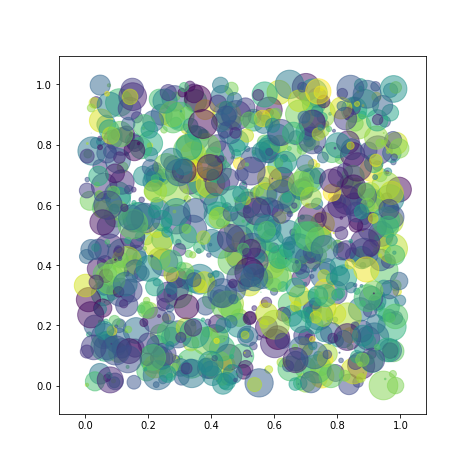

In [18]:
# PNG
Image(filename='benchmarking/matplotlib_fig.png')

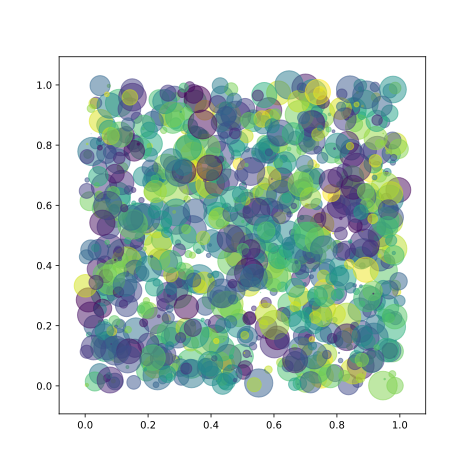

In [19]:
# SVG
SVG(filename='benchmarking/matplotlib_fig.svg')

## Show plotly.py images

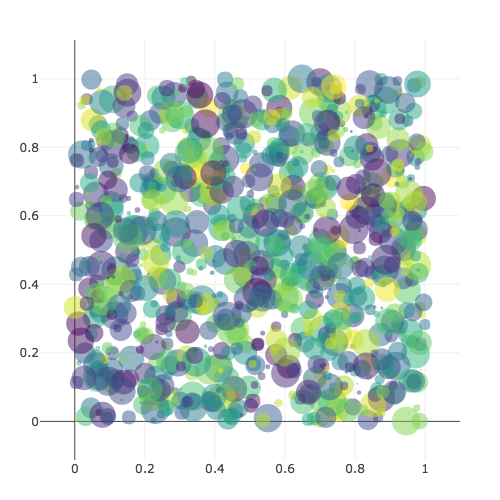

In [20]:
# PNG
Image(filename='benchmarking/plotly_fig.png')

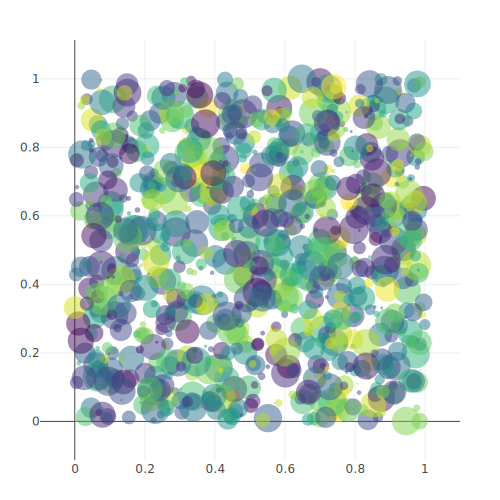

In [21]:
# SVG
SVG(filename='benchmarking/plotly_fig.svg')

## Show bokeh images

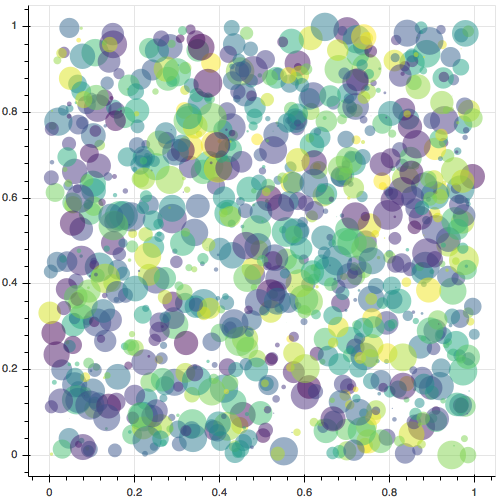

In [22]:
# PNG
Image(filename='benchmarking/bokeh_fig.png')

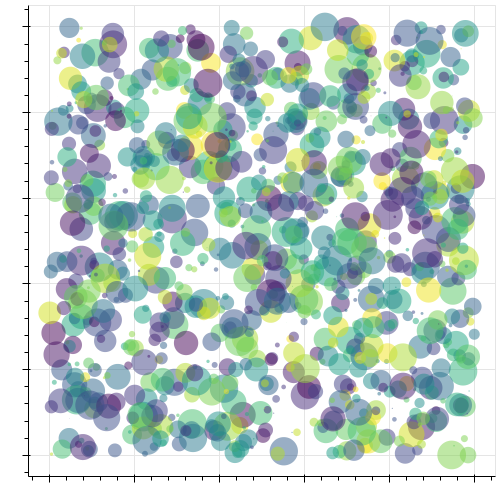

In [23]:
# SVG
SVG(filename='benchmarking/bokeh_fig.svg')

## Show altair images

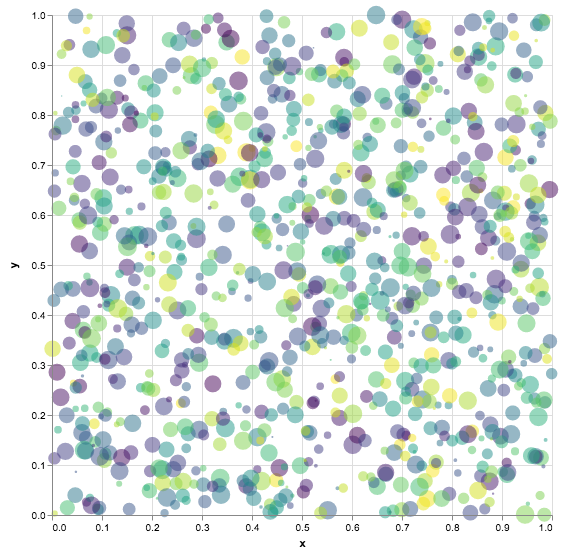

In [24]:
# PNG
Image(filename='benchmarking/altair_fig.png')

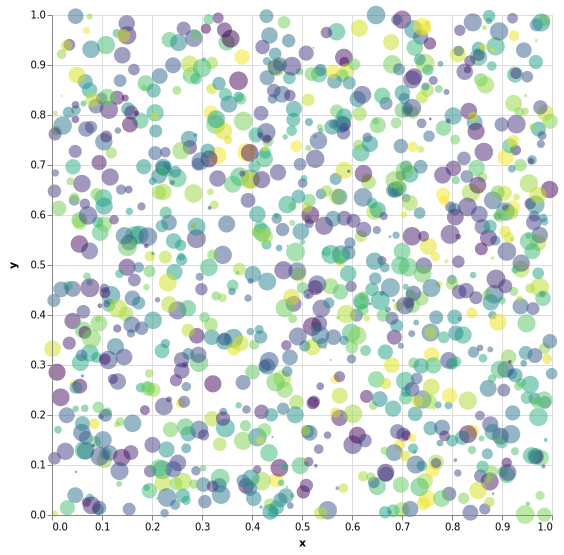

In [25]:
# SVG
SVG(filename='benchmarking/altair_fig.svg')

# Plot timing results

In [26]:
fig = go.FigureWidget()

# Add bar traces
formats = ['PNG', 'SVG']
text_opts = {'textposition': 'inside', 'textfont': {'color': 'white'}}
fig.add_bar(y=[plotly_png_timeit.average, plotly_svg_timeit.average],
            x=formats, name='plotly.py', text='plotly.py', **text_opts)

fig.add_bar(y=[matplotlib_png_timeit.average, matplotlib_svg_timeit.average],
            x=formats, name='matplotlib', text='matplotlib', **text_opts)
fig.add_bar(y=[bokeh_png_timeit.average, bokeh_svg_timeit.average],
            x=formats, name='bokeh', text='bokeh', **text_opts)
fig.add_bar(y=[altair_png_timeit.average, altair_svg_timeit.average],
            x=formats, name='altair', text='altair', **text_opts)

# Set labels
fig.layout.title = 'Image export benchmarks<br>(shorter is better)'
fig.layout.xaxis.title = 'Export format'
fig.layout.yaxis.title = 'Export time (s)'
fig.layout.showlegend = False
fig.layout.height = 500
fig.layout.width = 900

# View figure
fig

FigureWidget({
    'data': [{'name': 'plotly.py',
              'text': 'plotly.py',
              'textfont':…

In [27]:
pio.write_image(fig, 'benchmark_results.png', scale=2)

In [28]:
with open('./benchmark_results.pickle', 'wb') as f:
    pickle.dump(fig.to_dict(), f)